In this section, we will train the ViT model with a learning rate = 0.001 (0.0001, 0.001, 0.01) using a cosine learning rate scheduler initially.

The trained model is pushed to the
[hugging face hub](https://huggingface.co/sharren/vit-lr-0.001/tree/main)


*Early stopping is employed: stop training if there is no improvement in the evaluation metric (in this case, decrease in validation loss) for 10 evaluation steps.*

# Dependencies and Libraries

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

##Installation

In [ ]:
#!pip install transformers
!pip install accelerate -U
# !pip install transformers[torch]
!pip install datasets
!pip install tensorboard
# !pip install wandb
#!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
# install transformer from source
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-go7hq1ao
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-go7hq1ao
  Resolved https://github.com/huggingface/transformers.git to commit f6261d7d81edd036fc53bfede65fe91f01a661aa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.39.0.dev0-py3-none-any.whl size=8760392 sha256=c7ce68c7d176fe642e7aaf397282f56c4295fdb20e7a98306c13b38239965c0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-b17l6bxm/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


##Import

In [ ]:
import pandas as pd
from google.colab import userdata
import torch
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision.transforms import v2
from tqdm.notebook import tqdm
import shutil
from pathlib import Path
from datasets import load_dataset
from huggingface_hub import notebook_login
from tqdm.notebook import tqdm
# import wandb

# Load Dataset from Huggingface

In [ ]:
skin_dataset = load_dataset("sharren/originalSkin")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5128 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2884 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2003 [00:00<?, ? examples/s]

In [ ]:
skin_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5128
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2884
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2003
    })
})

In [ ]:
labels = skin_dataset["train"].features["label"].names

idx2label = {idx: label for idx, label in enumerate(labels)}
label2idx = {label: idx for idx, label in enumerate(labels)}

# Processor


In [ ]:
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224', do_rescale = False, return_tensors = 'pt')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

# Transformation

In [ ]:
# to apply what's in the default image processor along with the augmentation
image_mean, image_std = processor.image_mean, processor.image_std
normalize = v2.Normalize(mean=image_mean, std=image_std)

In [ ]:
from torchvision import transforms as v2
# Initial augmentation = only normalization
train_transform = v2.Compose([
    v2.Resize((processor.size["height"], processor.size["width"])),
    v2.ToTensor(),
    normalize
])

In [ ]:
test_transform = v2.Compose([
    v2.Resize((processor.size["height"], processor.size["width"])),
    v2.ToTensor(),
    normalize
])

In [ ]:
def train_transforms(examples):
    examples['pixel_values'] = [train_transform(image.convert("RGB")) for image in examples['image']]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [test_transform(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
# Set the transforms
skin_dataset['train'].set_transform(train_transforms)
skin_dataset['validation'].set_transform(test_transforms)
skin_dataset['test'].set_transform(test_transforms)

# Functions for Trainer

## Collate Function

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


## Compute Metrics Function

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(predictions, labels)
    precision = precision_score(labels, predictions, average='weighted',zero_division=0)
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



A warning occur when training
`UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples`.
This warning commonly occurs in multi-class classification problems when some classes are not predicted by the model. It's often caused by class imbalance or the model's inability to adequately learn certain classes.



> To address this warning for the current stage, zero_division parameter is set in precision_score to specify the behavior when a class has no predicted samples.  Use a numeric value (in this case, 0) to use as the precision when the denominator is zero.




To further address the root cause which is class imbalance issue, we will use data augmentation in the later stage.

## Feature Extractor

In [ ]:
from transformers import ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# Model

In [ ]:
model_id = 'google/vit-base-patch16-224'

In [ ]:
from transformers import ViTForImageClassification, ViTConfig

# Initialize a ViT base configuration
configuration = ViTConfig()

# No dropout initially
# configuration.attention_probs_dropout_prob = 0.32

# Set classification head
configuration.id2label={str(i): c for i, c in enumerate(labels)}
configuration.label2id={c: str(i) for i, c in enumerate(labels)}
# Instantiate the model with the custom configuration and classification head
model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    config=configuration,
    ignore_mismatched_sizes=True,)



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Trainer

## Arguments

In [ ]:
epochs=100

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
  output_dir="./vit-lr-0.001",
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  logging_strategy="epoch",
  num_train_epochs=epochs,
  fp16=True,
  learning_rate= 0.001, # 0.0001, 0.001, 0.01, 0.1, 1
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  metric_for_best_model="eval_loss", # early stopping criteria
  greater_is_better=False,
  lr_scheduler_type='cosine',
  # warmup_steps=warmup_steps,
  # logging_dir='logs', #tensorboard dir defaults to 'runs'
  # weight_decay=0.01, #defaults to 0
)

## Custom Trainer: Loss function

**Loss Function**

For consistency among models, the compute_loss is overidden so that it is similar to CategoricalCrossentropy in Tensorflow

*EfficientNet and ResNet will be trained with Tensorflow framework*

In [ ]:
import torch
import torch.nn as nn
from transformers import Trainer
from torch.optim.lr_scheduler import CosineAnnealingLR

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

## Apply Early Stopping



 The training will stop if there is no improvement in the evaluation metric (in this case, validation loss) for 10 evaluation steps.

In [ ]:
trainer = CustomTrainer(
    model,
    args,
    train_dataset=skin_dataset['train'],
    eval_dataset=skin_dataset['validation'],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(10, 0.0)],
    # optimizers=(optimizer, lr_scheduler),
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


# Fine-tuning
We can now finetune our model by just calling the train method:

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.078100,0.980193,0.670943,0.497287,0.670943,0.543782
2,0.951400,0.898940,0.668863,0.529932,0.668863,0.552909
3,0.923200,0.939051,0.670250,0.551602,0.670250,0.602016
4,0.919100,0.934881,0.680305,0.526125,0.680305,0.576371
5,0.891900,0.896563,0.682732,0.560848,0.682732,0.601392
6,0.852100,0.832954,0.692788,0.609925,0.692788,0.633703
7,0.830400,0.897995,0.678571,0.584858,0.678571,0.570083
8,0.797100,0.821120,0.683426,0.695658,0.683426,0.666154
9,0.788100,0.826163,0.696255,0.647590,0.696255,0.605072
10,0.779600,0.811924,0.704924,0.652254,0.704924,0.640694


***** train metrics *****
  epoch                    =          34.0
  total_flos               = 12583554575GF
  train_loss               =        0.7405
  train_runtime            =    1:21:35.28
  train_samples_per_second =       104.754
  train_steps_per_second   =         6.557


*The train metrics are saved as train_results.json (assesible in the hub)*

# Evaluation on validation set

A good learning rate
-  leads to improved performance metrics such as accuracy, precision, recall, or F1-score on the validation set.

- promotes stable training, exihibiting a smooth decrease in loss over time

- results in a decreasing training loss without significant overfitting (validation loss remains low)

In [ ]:
metrics = trainer.evaluate(skin_dataset['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       34.0
  eval_accuracy           =     0.7334
  eval_f1                 =     0.7133
  eval_loss               =     0.7065
  eval_precision          =     0.7056
  eval_recall             =     0.7334
  eval_runtime            = 0:00:38.48
  eval_samples_per_second =     74.942
  eval_steps_per_second   =      9.381


In [ ]:
print(trainer.state)

TrainerState(epoch=34.0, global_step=10914, max_steps=32100, logging_steps=500, eval_steps=500, save_steps=500, train_batch_size=16, num_train_epochs=100, num_input_tokens_seen=0, total_flos=1.3511488842154082e+19, log_history=[{'loss': 1.0781, 'grad_norm': 2.422405242919922, 'learning_rate': 0.0009997563447466272, 'epoch': 1.0, 'step': 321}, {'eval_loss': 0.9801927804946899, 'eval_accuracy': 0.6709431345353676, 'eval_precision': 0.49728711752188964, 'eval_recall': 0.6709431345353676, 'eval_f1': 0.5437820916930481, 'eval_runtime': 37.3274, 'eval_samples_per_second': 77.262, 'eval_steps_per_second': 9.671, 'epoch': 1.0, 'step': 321}, {'loss': 0.9514, 'grad_norm': 2.076770067214966, 'learning_rate': 0.0009990194998956315, 'epoch': 2.0, 'step': 642}, {'eval_loss': 0.8989401459693909, 'eval_accuracy': 0.6688626907073509, 'eval_precision': 0.5299319915521371, 'eval_recall': 0.6688626907073509, 'eval_f1': 0.5529090821435705, 'eval_runtime': 38.7619, 'eval_samples_per_second': 74.403, 'eval_s

In [ ]:
print(trainer.state.log_history)

[{'loss': 1.0781, 'grad_norm': 2.422405242919922, 'learning_rate': 0.0009997563447466272, 'epoch': 1.0, 'step': 321}, {'eval_loss': 0.9801927804946899, 'eval_accuracy': 0.6709431345353676, 'eval_precision': 0.49728711752188964, 'eval_recall': 0.6709431345353676, 'eval_f1': 0.5437820916930481, 'eval_runtime': 37.3274, 'eval_samples_per_second': 77.262, 'eval_steps_per_second': 9.671, 'epoch': 1.0, 'step': 321}, {'loss': 0.9514, 'grad_norm': 2.076770067214966, 'learning_rate': 0.0009990194998956315, 'epoch': 2.0, 'step': 642}, {'eval_loss': 0.8989401459693909, 'eval_accuracy': 0.6688626907073509, 'eval_precision': 0.5299319915521371, 'eval_recall': 0.6688626907073509, 'eval_f1': 0.5529090821435705, 'eval_runtime': 38.7619, 'eval_samples_per_second': 74.403, 'eval_steps_per_second': 9.313, 'epoch': 2.0, 'step': 642}, {'loss': 0.9232, 'grad_norm': 1.2313348054885864, 'learning_rate': 0.0009977901830455931, 'epoch': 3.0, 'step': 963}, {'eval_loss': 0.9390512704849243, 'eval_accuracy': 0.670

In [ ]:
loss = []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        loss.append(elem['loss'])
print(loss)

[1.0781, 0.9514, 0.9232, 0.9191, 0.8919, 0.8521, 0.8304, 0.7971, 0.7881, 0.7796, 0.7535, 0.7404, 0.7455, 0.747, 0.7263, 0.7203, 0.7194, 0.7029, 0.7129, 0.6895, 0.7066, 0.6895, 0.6918, 0.6818, 0.6538, 0.655, 0.6612, 0.6406, 0.64, 0.637, 0.622, 0.6193, 0.6058, 0.6047]


In [ ]:
print("Length of loss:", len(loss))

Length of loss: 34


In [ ]:
eval_loss = []
for elem in trainer.state.log_history:
    if 'eval_loss' in elem.keys():
        eval_loss.append(elem['eval_loss'])

eval_loss = eval_loss[:-1]
print(eval_loss)

[0.9801927804946899, 0.8989401459693909, 0.9390512704849243, 0.934880793094635, 0.8965628743171692, 0.8329538106918335, 0.8979945778846741, 0.8211200833320618, 0.8261629939079285, 0.8119240999221802, 0.7961071729660034, 0.7899047136306763, 0.8244765996932983, 0.7626777291297913, 0.7411332130432129, 0.7484477162361145, 0.724780797958374, 0.7469883561134338, 0.7173224091529846, 0.7422552108764648, 0.7527933120727539, 0.7132036685943604, 0.768975555896759, 0.7064515352249146, 0.7206926941871643, 0.719107985496521, 0.7313501834869385, 0.7939181327819824, 0.7089102864265442, 0.7511705160140991, 0.7483331561088562, 0.7289853096008301, 0.7299284934997559, 0.7085505723953247]


In [ ]:
print("Length of eval_loss:", len(eval_loss))

Length of eval_loss: 34


### Loss curve



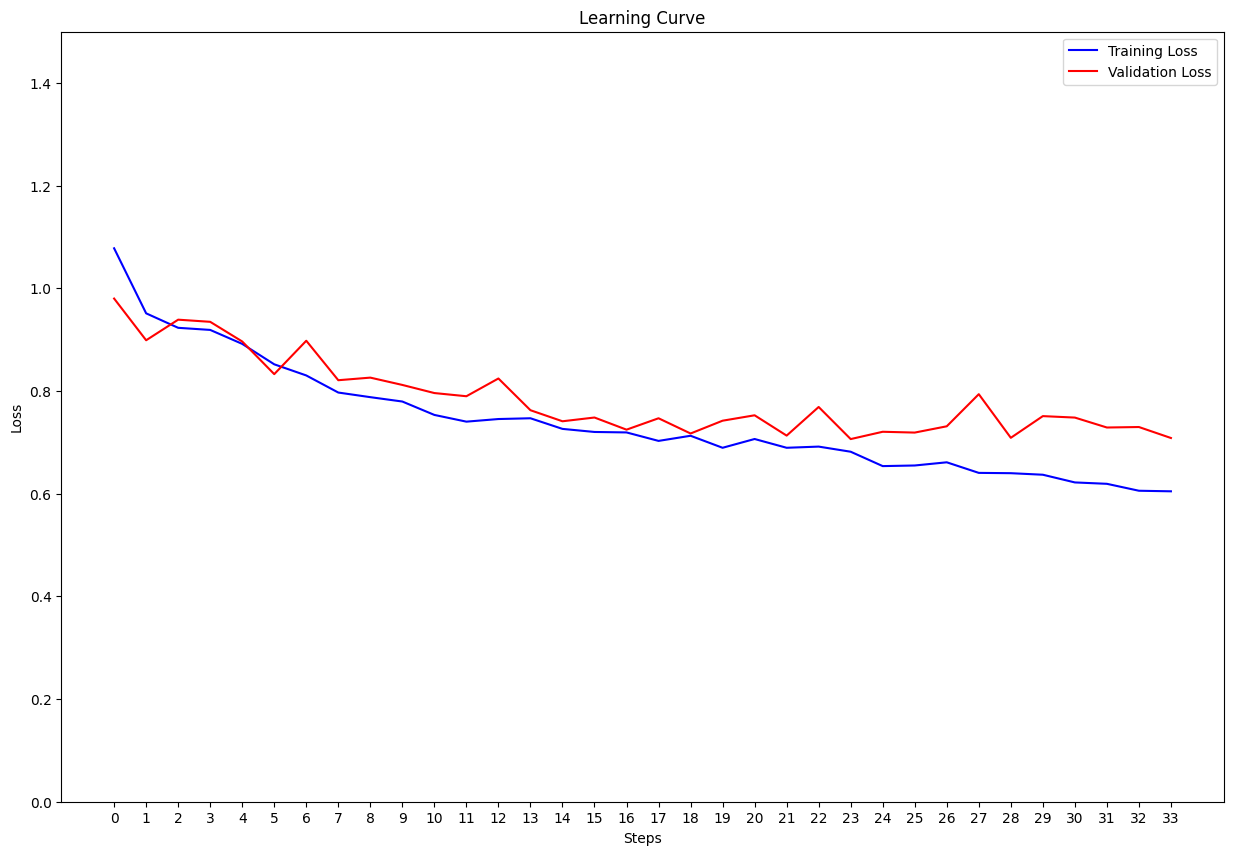

In [ ]:
import matplotlib.pyplot as plt

x_values = range(0, int(trainer.state.epoch), 1)
plt.figure(figsize=(15, 10))
plt.plot(x_values, loss, 'b-', label='Training Loss')
plt.plot(x_values, eval_loss, 'r-', label='Validation Loss')
plt.ylim(0,1.5)

plt.title('Learning Curve')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.xticks(range(0, int(trainer.state.epoch), 1))
plt.legend()

plt.show()


## Tensorboard

From the tensorboard, it shows the plots for training loss over steps,validation loss over steps, validation accuracy, gradient norms.

A stable/converging model should show:
- Smooth decrease in loss over time, sudden jumps may indicate instability
- Increasing accuracy
- Gradual decrease in gradient norms (indicate convergence)


[Access Tensorboard](https://huggingface.co/sharren/vit-lr-0.001/tensorboard)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir vit-lr-0.001/runs/Mar19_11-51-22_befed1cbff90

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

# Performance on Test Set

In [ ]:
outputs = trainer.predict(skin_dataset['test'])

In [ ]:
print(outputs.metrics)

{'test_loss': 0.7132281064987183, 'test_accuracy': 0.7324013979031453, 'test_precision': 0.7142864240816439, 'test_recall': 0.7324013979031453, 'test_f1': 0.7192440112274562, 'test_runtime': 26.5364, 'test_samples_per_second': 75.481, 'test_steps_per_second': 9.459}


# Push model to hub

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'skin-cancer',
    "tags": ['image-classification'],
}

if args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

events.out.tfevents.1710854039.befed1cbff90.172.4:   0%|          | 0.00/560 [00:00<?, ?B/s]